In [407]:
ratings_path = "./ratings.tsv"
rev_path = "./llm_reviews/gpt-4o-mini-2024-07-18_temp_0_1_pages_all.csv"
rev_path_reflect_5 = "./llm_reviews/gpt-4o-mini-2024-07-18_temp_0_1_reflect_5_pages_all.csv" #"./llm_reviews/gpt-4o-mini-2024-07-18_temp_0_1_pages_all.csv" #"./llm_reviews/gpt-4o-mini-2024-07-18_temp_0_1_ensemble_2_pages_all.csv"
rev_path_reflect_5_fs_1 = "./llm_reviews/gpt-4o-mini-2024-07-18_temp_0_1_fewshot_1_reflect_5_pages_all.csv" #"./llm_reviews/gpt-4o-mini-2024-07-18_temp_0_1_pages_all.csv" #"./llm_reviews/gpt-4o-mini-2024-07-18_temp_0_1_ensemble_2_pages_all.csv"
rev_path_reflect_5_ensemble_5 = "./llm_reviews/gpt-4o-mini-2024-07-18_temp_0_1_reflect_5_ensemble_5_pages_all.csv" #"./llm_reviews/gpt-4o-mini-2024-07-18_temp_0_1_pages_all.csv" #"./llm_reviews/gpt-4o-mini-2024-07-18_temp_0_1_ensemble_2_pages_all.csv"

In [411]:
# plot correlation between strength scores and significance scores for each model 
import pandas as pd
import numpy as np

from scipy.stats import pearsonr

def get_correlation(rev_path, ratings_path):
    df_rev = pd.read_csv(rev_path, index_col=0)
    df_true = pd.read_csv(ratings_path, sep='\t', index_col=0)
    merged_df = pd.merge(df_true, df_rev, on='paper_id', )

    sig_values = ["useful", "valuable", "important", "fundamental", "landmark"]
    strength_values = ["inadequate", "incomplete", "solid", "convincing", "compelling", "exceptional"]

    merged_df["true_strength_num"] = merged_df["strength"].apply(lambda x: strength_values.index(x))
    merged_df["pred_strength_num"] = merged_df["Strength of Evidence"].apply(lambda x: strength_values.index(x.lower()))

    merged_df["true_sig_num"] = merged_df["significance"].apply(lambda x: sig_values.index(x))
    merged_df["pred_sig_num"] = merged_df["Significance"].apply(lambda x: sig_values.index(x.lower()))

    strength_corr = (np.corrcoef(merged_df["true_strength_num"], merged_df["pred_strength_num"])[0, 1])
    sig_corr = (np.corrcoef(merged_df["true_sig_num"], merged_df["pred_sig_num"])[0, 1])

    strength_p = pearsonr(merged_df["true_strength_num"], merged_df["pred_strength_num"])
    sig_p = pearsonr(merged_df["true_sig_num"], merged_df["pred_sig_num"])

    print(rev_path)
    print("strength p = " + str(strength_p.pvalue) + ", sig_p = " + str(sig_p.pvalue))
    
    if np.isnan(sig_corr):
        sig_corr = 0
    
    if np.isnan(strength_corr):
        strength_corr = 0
    
    return sig_corr, strength_corr


correlations = np.array([get_correlation(rev_path, ratings_path),  # rev_path_reflect_5_fs_1
get_correlation(rev_path_reflect_5_fs_1, ratings_path),
get_correlation(rev_path_reflect_5_ensemble_5, ratings_path),
get_correlation(rev_path_reflect_5, ratings_path)])

./llm_reviews/gpt-4o-mini-2024-07-18_temp_0_1_pages_all.csv
strength p = 0.5987737553159901, sig_p = 0.7382848727980272
./llm_reviews/gpt-4o-mini-2024-07-18_temp_0_1_fewshot_1_reflect_5_pages_all.csv
strength p = 0.4676803667395656, sig_p = nan
./llm_reviews/gpt-4o-mini-2024-07-18_temp_0_1_reflect_5_ensemble_5_pages_all.csv
strength p = 0.10918751787005467, sig_p = 0.3886651712338329
./llm_reviews/gpt-4o-mini-2024-07-18_temp_0_1_reflect_5_pages_all.csv
strength p = 0.04960230766919809, sig_p = 0.0020797258032775557


/Users/ethantrepka/miniconda3/envs/adv/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/ethantrepka/miniconda3/envs/adv/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/var/folders/j8/f15cwy8d2y997yr276w5nd6m0000gn/T/ipykernel_60952/2172473547.py:25: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  sig_p = pearsonr(merged_df["true_sig_num"], merged_df["pred_sig_num"])


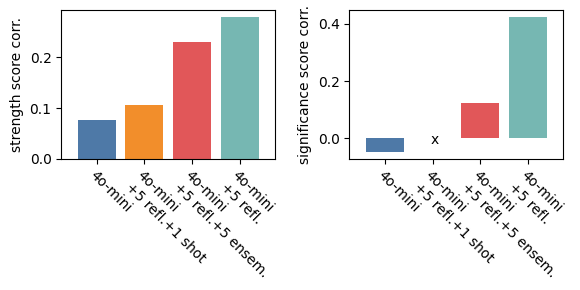

In [377]:
from copy import deepcopy

model_labels = ["4o-mini", "4o-mini\n+5 refl.+1 shot", "4o-mini\n+5 refl.+5 ensem.", "4o-mini\n+5 refl."]
model_colors = ['#4E79A7', '#F28E2B', '#E15759', '#76B7B2']

palette = deepcopy(model_colors)
palette.insert(0, '#777777')

fig, ax = plt.subplots(1,2,figsize=(6,3))
plt.sca(ax[0])

plt.bar(x = np.arange(4), height=correlations[:, 1], color=model_colors)
plt.ylabel("strength score corr.")
plt.xticks(ticks=np.arange(len(model_labels)), labels = model_labels, rotation=-45,  ha="left", rotation_mode="anchor")
plt.xlim([-0.75, len(model_labels)-0.25])

plt.sca(ax[1])
plt.bar(x = np.arange(4), height=correlations[:, 0], color=model_colors)
plt.ylabel("significance score corr.")
plt.xticks(ticks=np.arange(len(model_labels)), labels = model_labels, rotation=-45,  ha="left", rotation_mode="anchor")
plt.xlim([-0.75, len(model_labels)-0.25])
plt.text(x=1-.05, y=0-.02, s='x') # 1 shot sig correlation undefined because always predicted important

plt.tight_layout()
plt.show()


In [390]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def get_strength_and_significance(df, str_key, sig_key):
    strength_list = ["inadequate", "incomplete", "solid", "convincing", "compelling", "exceptional"]
    sig_list = ["useful", "valuable", "important", "fundamental", "landmark"]

    strengths = df[str_key].apply(lambda x: strength_list.index(x.lower())).to_numpy()
    strengths.sort()

    sigs = df[sig_key].apply(lambda x: sig_list.index(x.lower())).to_numpy()
    sigs.sort()

    return strengths, sigs

def plot_score_distributions(df):
    strength_list = ["inadequate", "incomplete", "solid", "convincing", "compelling", "exceptional"]
    sig_list = ["useful", "valuable", "important", "fundamental", "landmark"]

    strengths = df["strength"].apply(lambda x: strength_list.index(x)).to_numpy()
    strengths.sort()

    fig, axs = plt.subplots(1, 2, figsize=(6,4), width_ratios=[len(strength_list), len(sig_list)])
    plt.sca(axs[0])
    sns.histplot(x=strengths, discrete=True, shrink=0.8, stat='probability')
    plt.title("strength of evidence")
    plt.xticks(ticks=np.arange(len(strength_list)), labels = [str(i + 1) + ". " + strength_list[i] for i in range(len(strength_list))], rotation=-45,  ha="left", rotation_mode="anchor")
    plt.xlim([-0.75, len(strength_list)-0.25])

    sigs = df["significance"].apply(lambda x: sig_list.index(x)).to_numpy()
    sigs.sort()

    plt.sca(axs[1])
    sns.histplot(x=sigs, discrete=True, shrink=0.8, stat='probability')
    plt.title("significance")
    plt.xticks(ticks=np.arange(len(sig_list)), labels = [str(i + 1) + ". " + sig_list[i] for i in range(len(sig_list))], rotation=-45,  ha="left", rotation_mode="anchor")
    plt.xlim([-0.75, len(sig_list)-0.25])
    plt.tight_layout()

In [391]:
# given a ratings_path, and 4 model paths rev_path, rev_path_reflect_5, rev_path_reflect_5_fs_1, and rev_path_reflect_5_ensemble_5
df_true = pd.read_csv(ratings_path, sep='\t', index_col=0)

df_rev = pd.read_csv(rev_path, index_col=0)
df_rev_reflect_5 = pd.read_csv(rev_path_reflect_5, index_col=0)
df_rev_reflect_5_fs_1 = pd.read_csv(rev_path_reflect_5_fs_1, index_col=0)
df_rev_reflect_5_ensemble_5 = pd.read_csv(rev_path_reflect_5_ensemble_5, index_col=0)

merged_df = pd.merge(df_true, df_rev, on='paper_id', )

strengths_true, sigs_true = get_strength_and_significance(merged_df, str_key='strength', sig_key='significance')
strengths_rev, sigs_rev = get_strength_and_significance(df_rev, str_key='Strength of Evidence', sig_key='Significance')
strengths_rev_ref, sigs_rev_ref = get_strength_and_significance(df_rev_reflect_5, str_key='Strength of Evidence', sig_key='Significance')
strengths_rev_ref_fs, sigs_rev_ref_fs = get_strength_and_significance(df_rev_reflect_5_fs_1, str_key='Strength of Evidence', sig_key='Significance')
strengths_rev_ref_ens, sigs_rev_ref_ens = get_strength_and_significance(df_rev_reflect_5_ensemble_5, str_key='Strength of Evidence', sig_key='Significance')

model_labels = ["human", "4o-mini", "4o-mini\n+5 refl.+1 shot", "4o-mini\n+5 refl.+5 ensem.", "4o-mini\n+5 refl."]

model_types = []
strengths = np.concatenate((strengths_true, strengths_rev, strengths_rev_ref_fs, strengths_rev_ref_ens, strengths_rev_ref))
sigs = np.concatenate((sigs_true, sigs_rev,sigs_rev_ref_fs,sigs_rev_ref_ens,sigs_rev_ref))
for i in range(len(model_labels)):
    model_types = model_types + len(strengths_true) * [model_labels[i]]

"\nsns.histplot(x=strengths, hue=model_types, multiple='dodge', palette=palette)\nplt.show()\nsns.histplot(x=sigs, hue=model_types, multiple='dodge')\nplt.show()\n"

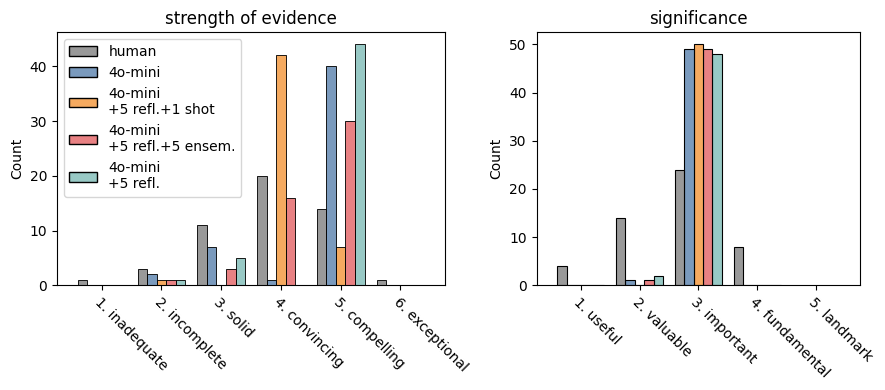

In [406]:
strength_list = ["inadequate", "incomplete", "solid", "convincing", "compelling", "exceptional"]
sig_list = ["useful", "valuable", "important", "fundamental", "landmark"]

#strengths = df["strength"].apply(lambda x: strength_list.index(x)).to_numpy()
#strengths.sort()

fig, axs = plt.subplots(1, 2, figsize=(9,4), width_ratios=[len(strength_list), len(sig_list)])
plt.sca(axs[0])
sns.histplot(x=strengths, discrete=True, shrink=0.8, hue=model_types, multiple='dodge', palette=palette, legend=True)
plt.title("strength of evidence")
plt.xticks(ticks=np.arange(len(strength_list)), labels = [str(i + 1) + ". " + strength_list[i] for i in range(len(strength_list))], rotation=-45,  ha="left", rotation_mode="anchor")
plt.xlim([-0.75, len(strength_list)-0.25])

#sigs = df["significance"].apply(lambda x: sig_list.index(x)).to_numpy()
#sigs.sort()

plt.sca(axs[1])
sns.histplot(x=sigs, discrete=True, shrink=0.8,  hue=model_types, multiple='dodge', palette=palette, legend=False)
plt.title("significance")
plt.xticks(ticks=np.arange(len(sig_list)), labels = [str(i + 1) + ". " + sig_list[i] for i in range(len(sig_list))], rotation=-45,  ha="left", rotation_mode="anchor")
plt.xlim([-0.75, len(sig_list)-0.25])
plt.tight_layout()

"""
sns.histplot(x=strengths, hue=model_types, multiple='dodge', palette=palette)
plt.show()
sns.histplot(x=sigs, hue=model_types, multiple='dodge')
plt.show()
"""